# Cinnamon AI Bootcamp 
## Anomaly detection using Guassian Mixture Model
`Name:` Nguyen Truong Phat

### Expectation
In one dimension, given an observation $x_i$ from $k^{th}$ cluster (parameterized by $\mu$ and $\sigma$). The probability of seeing $x_i$
$$\mathcal{N}(x_i|\mu_k,\sigma_k^2)=\frac{1}{\sqrt{2\pi\sigma_k^2}}exp(-\frac{(x_i-\mu_k)^2}{2\sigma_k^2})$$ 
for each $k = 1,2,3,4,...K$

- Without observing the data, the probability of $x_i$ is from the $k^{th}$ cluster
$$p(z_i=k)=\phi_k \\\text{ (the probability of a random point is drawn from }k^{th}\text{ distribution)}$$
This can be interpreted as the "weight" for $k$-th guassian distribution in the mixture of models, also known as the prior.

- The probability of observing an $x_i$ in the data is the weighted sum (corresponding with $\phi_k$ for each clusters) of all the K distribution function at the given point $x$ 
$$p(x_i)=\sum_{k=1}^K \mathcal{N}(x_i|\mu_k,\sigma_k^2)\phi_k$$

- Therefore, given an observation $x_i$, the likelihood of $x_i$ (posterior) belong to $k^{th}$ cluster can be calculated:
$$b_{ik}=p(\mu_k,\sigma_k^2|x_i) =\frac{\mathcal{N}(x_i|\mu_k,\sigma_k^2)p(z_i=k)}{p(x_i)}=\frac{\mathcal{N}(x_i|\mu_k,\sigma_k^2)\phi_k}{\sum_{k=1}^K \mathcal{N}(x_i|\mu_k,\sigma_k^2)\phi_k}\text{(proven)}$$

For multivariate guassian model, the normal can be calculated:
$$\mathcal{N}(x_i|\mu_k,\Sigma)=\frac{1}{(2\pi)^{d/2}}|\Sigma|^{-1/2}exp[-\frac{1}{2}(x_i-\mu_k)^T\Sigma^{-1}(x_i-\mu_k)]$$

Whereas, $\Sigma$ is a $d\times d$ covariance matrix that satifies:
- positive semi-definite
- symmetric along diagonal 

### Maximization
For each step, we update the parameters (in a multivariate style) as follow:
$$ m_k=\sum_i b_{ik} \\ \text{(sum of all likelihood allocated to cluster k)}$$ 

$$\hat{\phi}_k = \frac{m_k}{m} \\ \text{(fraction of total likelihood)}$$

$$ \hat{\mu}_k = \frac{1}{m_k}\sum_i b_{ik}x_i \\ \text{(Weighted mean of assigned data)}$$

$$\hat{\Sigma}_k = \frac{1}{m_k} \sum_i b_{ik}(x_i-\hat{\mu}_k)^T(x_i-\hat{\mu}_k) \\ \text{(Weighted covariance of assigned data)}$$

Each step **strictly** (theoretically) increases the log-likelihood of our model 
$$logp(X)=\sum_i log \left[ \sum_c \pi_c \mathcal{N}(x_i;\mu _c,\Sigma_c) \right]$$

### Anomaly detection
For anomaly detection, we can then first calculate the probability of $x_i$ to be drawn from our mixture of Gaussian:
$$ p(x_i)=\sum_{k=1}^K \mathcal{N}(x_i|\mu_k,\sigma_k^2)\phi_k $$
If $p(x_i) < \lambda $ (which is the threshold we specify in advance) then we will consider $x_i$ to be abnormal 

In this case, we can consider the anomaly detection as a classification problem, then we can use classification techniques and metrics to work with it. This time, we want to choose threshold that maximizes the Fscore of the classification task:
$$\lambda = \underset{\lambda}{argmax} (Fscore)$$

## References
[1] [Machine Learning TV - Guassian Mixture Model for Clustering](https://www.youtube.com/watch?v=DODphRRL79c)<br>
[2] [Geeksforgeeks - Guassian Mixture Model](https://www.geeksforgeeks.org/gaussian-mixture-model/)<br>
[3] [Alexander Ihler - Gaussian Mixture Models and EM](https://www.youtube.com/watch?v=qMTuMa86NzU) <br>
[4] [Siraj Raval - Gaussian Mixture Models](https://www.youtube.com/channel/UChIaUcs3tho6XhyU6K6KMrw/search?query=gaussian+mixture)<br>
[5] https://stats.stackexchange.com/questions/91045/can-a-multivariate-distribution-with-a-singular-covariance-matrix-have-a-density<br>
[6] https://math.stackexchange.com/questions/503476/multivariate-gaussian-density-from-singular-covariance


## Implementation
### Import libraries

In [88]:
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

Traceback (most recent call last):
  File "/home/phat-ngu/.conda/envs/tf2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/phat-ngu/.conda/envs/tf2/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [59]:
class GaussianMixtureModel:
    
    # Notation
    # dim: dimension of the data
    # cov: covariance matrix
    # n_clusters: number of clusters
    # N: normal distribution
    # m: number of data points
    # k: k-th cluster
    # i: i-th sample
    
    def __init__(self,n_clusters=5):
        
        # Number of clusters that the model converge into
        self.n_clusters = n_clusters
        
        # Vectorization of different guassian distribution
        # Each line is a distribution parameterized by mu and sigma
        self.gaussians = {}
        
        # init mu, shape = (K x dim)
        self.gaussians['mu'] = None
        
        # init cov matrix, shape = (K x dim x dim)
        self.gaussians['cov'] = None
        
        # init prior (sum to 1), shape = (1,K)
        self.gaussians['prior'] = None
        
        # dimension of data
        self.dim = None
        
        # matrix of likelihood of data point to each cluster, shape (m,K)
        self.likelihood = None
        
        # matrix of normal prob of each data point, shape (m,K)
        self.normal_matrix = None
        
        # save history
        self.history = {}
        self.history['log_likelihood'] = []
        
        
        
    def createCov(self):
        # Create a random covaraince matrix that positive definite
        
        while True:
            A = np.random.normal(size=(self.dim,1))
            B= A*A.T
            # Make sure the matrix is invertible and positive definite
            if np.isfinite(np.linalg.cond(B)) and np.linalg.det(B)>0:
                break
            else:
                continue
        return B
    
   
    def normal(self,X,k): 
        # Given the list of observation X is from a cluster, what's the likelihood of seeing X.
        # Return shape: (m,1)
        # Get dimension of data
        dim = X.shape[1]
        
        # retrieve mu and covariance matrix from cluster k
        mu_k = self.gaussians['mu'][k]
        cov_k = self.gaussians['cov'][k]

        var = multivariate_normal(mean=mu_k, cov=cov_k,allow_singular=True)
        result = np.expand_dims(var.pdf(X),1)
        return  result

    
    
    
    def proba(self,X):
        # The probability of observing x_i in the data. 
        # Return shape: (m,1)
        
        # Get number of data
        m = X.shape[0]
        
        # Retrieve prior
        prior = self.gaussians['prior']
        
        # Get dimension of data
        dim = X.shape[1]
        
        # initialize array of size (m,k), each line represents normal(x_i,k) for each cluster k
        normal_matrix = np.empty((m,0))
        
        # for each cluster, append the N result to the right of the matrix
        for k in range(self.n_clusters):
            normal_k = self.normal(X,k)
            normal_matrix = np.hstack((normal_matrix,normal_k))
        self.normal_matrix = normal_matrix
        
        # times with prior for each cluster then sum for each line
        proba = np.sum(normal_matrix*prior,axis=1)
        return np.expand_dims(proba,1)
        
    def step(self,X):
        
        # Get number of data
        m = X.shape[0]
        
        # Get dimension of data
        dim = X.shape[1]
        
        p = self.proba(X)
        # Matrix of likelihood. Shape of (m,k)
        likelihood = np.empty((m,0))
        
        # EXPECTATION
        for k in range(self.n_clusters):
            # retrieve mu, prior and covariance matrix
            mu_k = self.gaussians['mu'][k]
            cov_k = self.gaussians['cov'][k]
            prior_k = self.gaussians['prior'][0][k]
           
            
            # compute normal N(x|mu,Sigma)
            
            N_k = self.normal(X,k)
            # compute likehood at k-th
            lh_k = N_k*prior_k/p
            # likelihood, append to the right
            likelihood = np.hstack((likelihood,lh_k))
            
        
        self.likelihood = likelihood
    
        # MAXIMIZATION

        # Sum of all likelihood allocated to cluster k. Shape (1,k)
        m_k = np.sum(likelihood,axis=0)
        # Update prior and expand dim to (1,K)
        self.gaussians['prior'] = np.expand_dims(m_k/m,axis=0)

        # Update mean
        for k in range(self.n_clusters):
            # likelihood at k-th. shape (m,1)
            lh_k = np.expand_dims(likelihood[:,k],1)
            self.gaussians['mu'][k] = 1/m_k[k]*np.sum(X*lh_k,axis=0)
              
        # Update cov
        for k in range(self.n_clusters):
            
            # retrieve mu_k
            mu_k = self.gaussians['mu'][k]
            cov = np.zeros((dim,dim))
            
            for i in range(m):
                
                diff = np.expand_dims((X[i]-mu_k),0)
                cov += likelihood[i][k]*(diff.T.dot(diff))
            cov_k=cov/m_k[k]

        
            self.gaussians['cov'][k] = cov_k
            
        
    
    def log_likelihood(self,X):
        
        m = X.shape[0]

        # Retrieve prior
        prior = self.gaussians['prior']
    
        normal_matrix = np.empty((m,0))
        
        # for each cluster, append the N result to the right of the matrix
        for k in range(self.n_clusters):
            normal_k = self.normal(X,k)
            normal_matrix = np.hstack((normal_matrix,normal_k))

        return np.log((normal_matrix*prior).sum(axis=1)).sum()
    
    def fit(self,X, max_iters=15):
        
        m = X.shape[0]

        # Get dim of data
        self.dim = X.shape[1]
        
        # init mu, shape = (K x dim)
        mulist=[]
        for k in range(self.n_clusters):
            random_mu = X[np.random.randint(low=0,high=len(X))]
            mulist.append(random_mu)
        self.gaussians['mu'] = np.array(mulist)

        # init covariance matrixes based on different sample of data, shape = (K x dim x dim)
        # Make sure every k-th covariance has det > 0
        self.gaussians['cov'] = np.array([self.createCov() for i in range(self.n_clusters)])

        
        # init prior (sum to 1), shape = (1,K)
        self.gaussians['prior']=np.random.dirichlet(np.ones(self.n_clusters),size=1)
                              
        
        for i in range(max_iters):
            print("step ",i,end=' ')
            # EM 
            self.step(X)
            
            # calculate log likelihood
            log_lh = self.log_likelihood(X)
            
            
            self.history['log_likelihood'].append(log_lh)
            print("log likelihood: ",log_lh)
        
    def predict(self,X):
        return self.likelihood.argmax(axis=1)

# Load data

In [60]:
from scipy.io import loadmat
data = loadmat('cardio.mat')
X = data['X']
Y = data['y'][:,0]
X_pos = X[Y==1]
X_neg = X[Y==0]

# Fit the model

In [67]:
# If get an error..please kindly run again, it works like magic
max_iters = 15
model = GaussianMixtureModel(n_clusters=3)
model.fit(X_neg,max_iters=max_iters)


step  0 log likelihood:  -29819.326706640488
step  1 log likelihood:  -25421.002210175368
step  2 log likelihood:  -13532.026188359003
step  3 log likelihood:  -21652.710596027628
step  4 log likelihood:  -20318.235195288253
step  5 log likelihood:  -18318.920936420152
step  6 log likelihood:  -19959.643367702596
step  7 log likelihood:  -19566.53311358596
step  8 log likelihood:  -17268.41623668353
step  9 log likelihood:  -19246.511764556955
step  10 log likelihood:  -14773.899347619334
step  11 log likelihood:  -18626.188447086162
step  12 log likelihood:  -11183.19993805412
step  13 log likelihood:  -18798.762850170533
step  14 log likelihood:  -10355.507193873642


In [68]:
model.predict(X_neg)

array([1, 1, 1, ..., 0, 0, 0])

Text(0, 0.5, 'log likelihood')

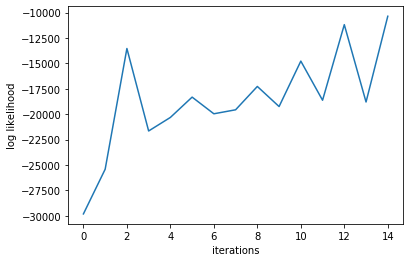

In [71]:
import matplotlib.pyplot as plt
plt.plot(range(0,max_iters),model.history['log_likelihood'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")

Theoretically speaking, the log likelihood should strictly increase every EM steps. But this fluctuates a lot

# Test on 2D Data

In [72]:
from sklearn.decomposition import PCA
# We use PCA to chop down component for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_neg)

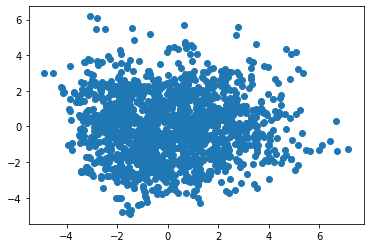

In [73]:
%matplotlib inline
plt.scatter(X_pca[:,0],X_pca[:,1])

step  0 log likelihood:  -6936.498042841801
step  1 log likelihood:  -6881.033094855808
step  2 log likelihood:  -6863.089359218
step  3 log likelihood:  -6853.1139641404225
step  4 log likelihood:  -6846.103005940182
step  5 log likelihood:  -6840.786948358567
step  6 log likelihood:  -6836.593528419803
step  7 log likelihood:  -6833.16042820256
step  8 log likelihood:  -6830.221247496595
step  9 log likelihood:  -6827.586635106269
step  10 log likelihood:  -6825.138137541355
step  11 log likelihood:  -6822.813001653121
step  12 log likelihood:  -6820.5832604964835
step  13 log likelihood:  -6818.437720031083
step  14 log likelihood:  -6816.3710552946595


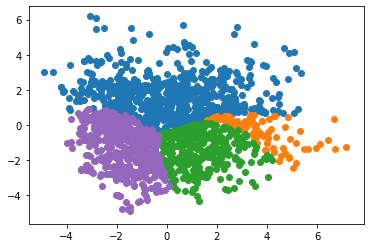

In [75]:
# color
n_clusters=5
GMM = GaussianMixtureModel(n_clusters=n_clusters)
GMM.fit(X_pca)
pred = GMM.predict(X_pca)
for i in range(n_clusters):
    plt.scatter(X_pca[pred==i][:,0],X_pca[pred==i][:,1])

Text(0, 0.5, 'log likelihood')

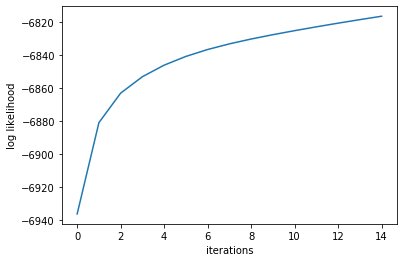

In [76]:
import matplotlib.pyplot as plt
plt.plot(range(0,max_iters),GMM.history['log_likelihood'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")

This time, with low dimensional data, we can see the smooth curve without fluctuation. We can then blame the curse of dimension :D

# Another 2D data

In [81]:
# We generate a dummy data
test_data = np.vstack([np.random.multivariate_normal([0,0],np.identity(2), size=(500,)),
                       np.random.multivariate_normal([-1,3],np.array([[2, 1],
                                                                      [1, 1]]), size=(500,))])

## See how the algo converge..with animation

![img](final.gif)

step  0 log likelihood:  -3597.0089883804017


<IPython.core.display.Javascript object>


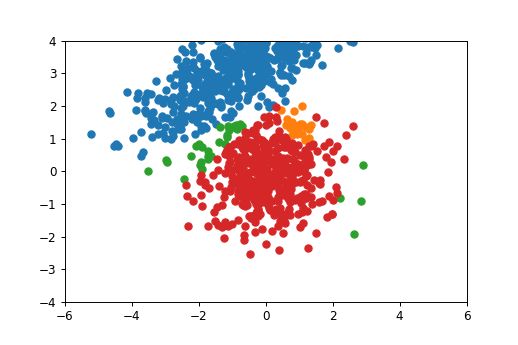

In [87]:
n_clusters=4
GMM = GaussianMixtureModel(n_clusters=n_clusters)
GMM.fit(test_data,max_iters=1)

pred = GMM.predict(test_data)
def update(curr):
    if curr==0:
        time.sleep(1)
    # check if animation is at the last frame, and if so, stop the animation a
    plt.cla()
    plt.axis([-6,6,-4,4])
    GMM.step(test_data)
    pred = GMM.predict(test_data)
    if curr == 50: 
        a.event_source.stop()
    for i in range(n_clusters):
        plt.scatter(test_data[pred==i][:,0],test_data[pred==i][:,1])
    
    
fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=300)